In [20]:
using ModelingToolkit
using Plots
using DifferentialEquations

In [21]:
@variables t
D = Differential(t)
include("healthy_human_parameters.jl")
include("biatrial_parameters.jl")
include("circulatory_system_components.jl")

CR

# Elastance function

In [22]:
function Elastance(t, E_min, E_max, T, T_es, T_ep, Eshift)
    # Get time relative to start of cycle
    t_i = rem(t + (1 - Eshift) * T, T)

    E_p = (t_i <= T_es) * (1 - cos(t_i / T_es * pi)) / 2 +
         (t_i > T_es) * (t_i <= T_ep) * (1 + cos((t_i - T_es) / (T_ep - T_es) * pi)) / 2 +
         (t_i > T_ep) * 0

    E = E_min + (E_max - E_min) * E_p

    return E
end


Elastance (generic function with 1 method)

# Healthy Human

In [23]:
# Heart chambers
@named LV = HeartChamber(V_0=v0_lv, p_0=p0_lv, E_min=Emin_lv, E_max=Emax_lv, T=T, T_es=Tes_lv, T_ep=Ted_lv, Eshift=0.0)
@named LA = HeartChamber(V_0=v0_la, p_0=p0_la, E_min=Emin_la, E_max=Emax_la, T=T, T_es=Tpww_la / 2, T_ep=Tpww_la, Eshift=Tpwb_la)
@named RV = HeartChamber(V_0=v0_rv, p_0=p0_rv, E_min=Emin_rv, E_max=Emax_rv, T=T, T_es=Tes_rv, T_ep=Ted_rv, Eshift=0.0)
@named RA = HeartChamber(V_0=v0_ra, p_0=p0_ra, E_min=Emin_ra, E_max=Emax_ra, T=T, T_es=Tpww_ra / 2, T_ep=Tpww_ra, Eshift=Tpwb_ra)

# Valves
@named AV = HeartValve(CQ=CQ_AV)
@named MV = HeartValve(CQ=CQ_MV)
@named TV = HeartValve(CQ=CQ_TV)
@named PV = HeartValve(CQ=CQ_PV)

# Systemic circulation
@named SAS = CRL(C=Csas, R=Rsas, L=Lsas)
@named SAT = CRL(C=Csat, R=Rsat, L=Lsat)
@named SAR = Resistor(R=Rsar)
@named SCP = Resistor(R=Rscp)
@named SVN = CR(R=Rsvn, C=Csvn)

# Pulmonary circulatioin
@named PAS = CRL(C=Cpas, R=Rpas, L=Lpas)
@named PAT = CRL(C=Cpat, R=Rpat, L=Lpat)
@named PAR = Resistor(R=Rpar)
@named PCP = Resistor(R=Rpcp)
@named PVN = CR(R=Rpvn, C=Cpvn);

In [24]:
p_lv_pt = plot(xlabel="t (s)", ylabel="Pressure (mmHg)",title = "(a) Left Ventricle", legend=false)
p_rv_pt = plot(xlabel="t (s)", ylabel="Pressure (mmHg)",title = "(b) Right Ventricle", legend=false)
p_la_pt = plot(xlabel="t (s)", ylabel="Pressure (mmHg)",title = "(c) Left Atrium", legend=false)
p_ra_pt = plot(xlabel="t (s)", ylabel="Pressure (mmHg)",title = "(d) Right Atrium", legend=false)
p_lv_pv = plot(xlabel="Volume (ml)", ylabel="Pressure (mmHg)",title = "(e) Left Ventricle", legend=false)
p_rv_pv = plot(xlabel="Volume (ml)", ylabel="Pressure (mmHg)",title = "(f) Right Ventricle", legend=false)
p_la_pv = plot(xlabel="Volume (ml)", ylabel="Pressure (mmHg)",title = "(g) Left Atrium", legend=false)
p_ra_pv = plot(xlabel="Volume (ml)", ylabel="Pressure (mmHg)",title = "(h) Right Atrium", legend=false)
p_ao_pt = plot(xlabel="t (s)", ylabel="Pressure (mmHg)",title = "(i) Aorta", legend=false)
p_pa_pt = plot(xlabel="t (s)", ylabel="Pressure (mmHg)",title = "(j) Pulmonary Artery", legend=false)

In [25]:
circ_eqs = [
    connect(LV.out, AV.in)
    connect(AV.out, SAS.in)
    connect(SAS.out, SAT.in)
    connect(SAT.out, SAR.in)
    connect(SAR.out, SCP.in)
    connect(SCP.out, SVN.in)
    connect(SVN.out, RA.in)
    connect(RA.out, TV.in)
    connect(TV.out, RV.in)
    connect(RV.out, PV.in)
    connect(PV.out, PAS.in)
    connect(PAS.out, PAT.in)
    connect(PAT.out, PAR.in)
    connect(PAR.out, PCP.in)
    connect(PCP.out, PVN.in)
    connect(PVN.out, LA.in)
    connect(LA.out, MV.in)
    connect(MV.out, LV.in)
];

# Create ODE system
@named _circ_model = ODESystem(circ_eqs, t)
@named circ_model = compose(_circ_model,
[LV, RV, LA, RA, AV, MV, PV, TV, SAS, SAT, SAR, SCP, SVN, PAS, PAT, PAR, PCP, PVN])
circ_sys = structural_simplify(circ_model)

#Initial conditions for ODEs
u0 = [
    LV.V => LV_Vt0
    LV.p => (LV_Vt0 - v0_lv) * Emin_lv + p0_lv
    RV.V => RV_Vt0
    RV.p => (RV_Vt0 - v0_rv) * Emin_rv + p0_rv
    LA.V => LA_Vt0
    RA.V => RA_Vt0
    SAS.C.p => pt0sas
    SAS.C.V => pt0sas * Csas
    SAS.L.q => qt0sas
    SAT.C.p => pt0sat
    SAT.C.V => pt0sat * Csat
    SAT.L.q => qt0sat
    SVN.C.p => pt0svn
    SVN.C.V => pt0svn * Csvn
    PAS.C.p => pt0pas
    PAS.C.V => pt0pas * Cpas
    PAS.L.q => qt0pas
    PAT.C.p => pt0pat
    PAT.C.V => pt0pat * Cpat
    PAT.L.q => qt0pat
    PVN.C.p => pt0pvn
    PVN.C.V => pt0pvn * Cpvn
];

# Solve system of ODEs
prob = ODAEProblem(circ_sys, u0, (0.0, 20.0))
sol = solve(prob, RK4(), reltol=1e-9, abstol=1e-12, saveat=19:0.01:20)
# display(sol)
plot!(p_rv_pt, (sol.t.-19.0), sol[circ_sys.RV.p], linewidth=2, linecolor=:blue)
plot!(p_ra_pt, (sol.t.-19.0), sol[circ_sys.RA.p], linewidth=2, linecolor=:blue)
plot!(p_lv_pt, (sol.t.-19.0), sol[circ_sys.LV.p], linewidth=2, linecolor=:blue)
plot!(p_la_pt, (sol.t.-19.0), sol[circ_sys.LA.p], linewidth=2, linecolor=:blue)
plot!(p_rv_pv, sol[circ_sys.RV.V], sol[circ_sys.RV.p], linewidth=2, linecolor=:blue)
plot!(p_ra_pv, sol[circ_sys.RA.V], sol[circ_sys.RA.p], linewidth=2, linecolor=:blue)
plot!(p_lv_pv, sol[circ_sys.LV.V], sol[circ_sys.LV.p], linewidth=2, linecolor=:blue)
plot!(p_la_pv, sol[circ_sys.LA.V], sol[circ_sys.LA.p], linewidth=2, linecolor=:blue)
plot!(p_ao_pt, (sol.t.-19.0), sol[circ_sys.SAS.C.p], linewidth=2, linecolor=:blue)
plot!(p_pa_pt, (sol.t.-19.0), sol[circ_sys.PAS.C.p], linewidth=2, linecolor=:blue);


# Pig

In [26]:
# Heart chambers
@named LV = HeartChamber(V_0=v0_lv_ba, p_0=p0_lv_ba, E_min=Emin_lv_ba, E_max=Emax_lv_ba, T=T_ba, T_es=Tes_lv_ba, T_ep=Ted_lv_ba, Eshift=0.0)
@named LA = HeartChamber(V_0=v0_la_ba, p_0=p0_la_ba, E_min=Emin_la_ba, E_max=Emax_la_ba, T=T_ba, T_es=Tpww_la_ba / 2, T_ep=Tpww_la_ba, Eshift=Tpwb_la_ba)
@named RV = HeartChamber(V_0=v0_rv_ba, p_0=p0_rv_ba, E_min=Emin_rv_ba, E_max=Emax_rv_ba, T=T_ba, T_es=Tes_rv_ba, T_ep=Ted_rv_ba, Eshift=0.0)
@named RA = HeartChamber(V_0=v0_ra_ba, p_0=p0_ra_ba, E_min=Emin_ra_ba, E_max=Emax_ra_ba, T=T_ba, T_es=Tpww_ra_ba / 2, T_ep=Tpww_ra_ba, Eshift=Tpwb_ra_ba)

# Valves
@named AV = HeartValve(CQ=CQ_AV_ba)
@named MV = HeartValve(CQ=CQ_MV_ba)
@named TV = HeartValve(CQ=CQ_TV_ba)
@named PV = HeartValve(CQ=CQ_PV_ba)

# Systemic circulation
@named SAS = CRL(C=Csas_ba, R=Rsas_ba, L=Lsas_ba)
@named SAT = CRL(C=Csat_ba, R=Rsat_ba, L=Lsat_ba)
@named SAR = Resistor(R=Rsar_ba)
@named SCP = Resistor(R=Rscp_ba)
@named SVN = CR(R=Rsvn_ba, C=Csvn_ba)

# Pulmonary circulatioin
@named PAS = CRL(C=Cpas_ba, R=Rpas_ba, L=Lpas_ba)
@named PAT = CRL(C=Cpat_ba, R=Rpat_ba, L=Lpat_ba)
@named PAR = Resistor(R=Rpar_ba)
@named PCP = Resistor(R=Rpcp_ba)
@named PVN = CR(R=Rpvn_ba, C=Cpvn_ba);

In [27]:
circ_eqs = [
    connect(LV.out, AV.in)
    connect(AV.out, SAS.in)
    connect(SAS.out, SAT.in)
    connect(SAT.out, SAR.in)
    connect(SAR.out, SCP.in)
    connect(SCP.out, SVN.in)
    connect(SVN.out, RA.in)
    connect(RA.out, TV.in)
    connect(TV.out, RV.in)
    connect(RV.out, PV.in)
    connect(PV.out, PAS.in)
    connect(PAS.out, PAT.in)
    connect(PAT.out, PAR.in)
    connect(PAR.out, PCP.in)
    connect(PCP.out, PVN.in)
    connect(PVN.out, LA.in)
    connect(LA.out, MV.in)
    connect(MV.out, LV.in)
];

# Create ODE system
@named _circ_model = ODESystem(circ_eqs, t)
@named circ_model = compose(_circ_model,
[LV, RV, LA, RA, AV, MV, PV, TV, SAS, SAT, SAR, SCP, SVN, PAS, PAT, PAR, PCP, PVN])
circ_sys = structural_simplify(circ_model)

#Initial conditions for ODEs
u0 = [
    LV.V => LV_Vt0_ba
    LV.p => (LV_Vt0_ba - v0_lv_ba) * Emin_lv_ba + p0_lv_ba
    RV.V => RV_Vt0_ba
    RV.p => (RV_Vt0_ba - v0_rv_ba) * Emin_rv_ba + p0_rv_ba
    LA.V => LA_Vt0_ba
    RA.V => RA_Vt0_ba
    SAS.C.p => pt0sas_ba
    SAS.C.V => pt0sas_ba * Csas_ba
    SAS.L.q => qt0sas_ba
    SAT.C.p => pt0sat_ba
    SAT.C.V => pt0sat_ba * Csat_ba
    SAT.L.q => qt0sat_ba
    SVN.C.p => pt0svn_ba
    SVN.C.V => pt0svn_ba * Csvn_ba
    PAS.C.p => pt0pas_ba
    PAS.C.V => pt0pas_ba * Cpas_ba
    PAS.L.q => qt0pas_ba
    PAT.C.p => pt0pat_ba
    PAT.C.V => pt0pat_ba * Cpat_ba
    PAT.L.q => qt0pat_ba
    PVN.C.p => pt0pvn_ba
    PVN.C.V => pt0pvn_ba * Cpvn_ba
];

# Solve system of ODEs
prob = ODAEProblem(circ_sys, u0, (0.0, 20.0))
sol = solve(prob, RK4(), reltol=1e-9, abstol=1e-12, saveat=19:0.01:20)
# display(sol)
plot!(p_rv_pt, (sol.t.-19.0), sol[circ_sys.RV.p], linewidth=2, linestyle=:dash, linecolor=:red)
plot!(p_ra_pt, (sol.t.-19.0), sol[circ_sys.RA.p], linewidth=2, linestyle=:dash, linecolor=:red)
plot!(p_lv_pt, (sol.t.-19.0), sol[circ_sys.LV.p], linewidth=2, linestyle=:dash, linecolor=:red)
plot!(p_la_pt, (sol.t.-19.0), sol[circ_sys.LA.p], linewidth=2, linestyle=:dash, linecolor=:red)
plot!(p_rv_pv, sol[circ_sys.RV.V], sol[circ_sys.RV.p], linewidth=2, linestyle=:dash, linecolor=:red)
plot!(p_ra_pv, sol[circ_sys.RA.V], sol[circ_sys.RA.p], linewidth=2, linestyle=:dash, linecolor=:red)
plot!(p_lv_pv, sol[circ_sys.LV.V], sol[circ_sys.LV.p], linewidth=2, linestyle=:dash, linecolor=:red)
plot!(p_la_pv, sol[circ_sys.LA.V], sol[circ_sys.LA.p], linewidth=2, linestyle=:dash, linecolor=:red)
plot!(p_ao_pt, (sol.t.-19.0), sol[circ_sys.SAS.C.p], linewidth=2, linestyle=:dash, linecolor=:red)
plot!(p_pa_pt, (sol.t.-19.0), sol[circ_sys.PAS.C.p], linewidth=2, linestyle=:dash, linecolor=:red);

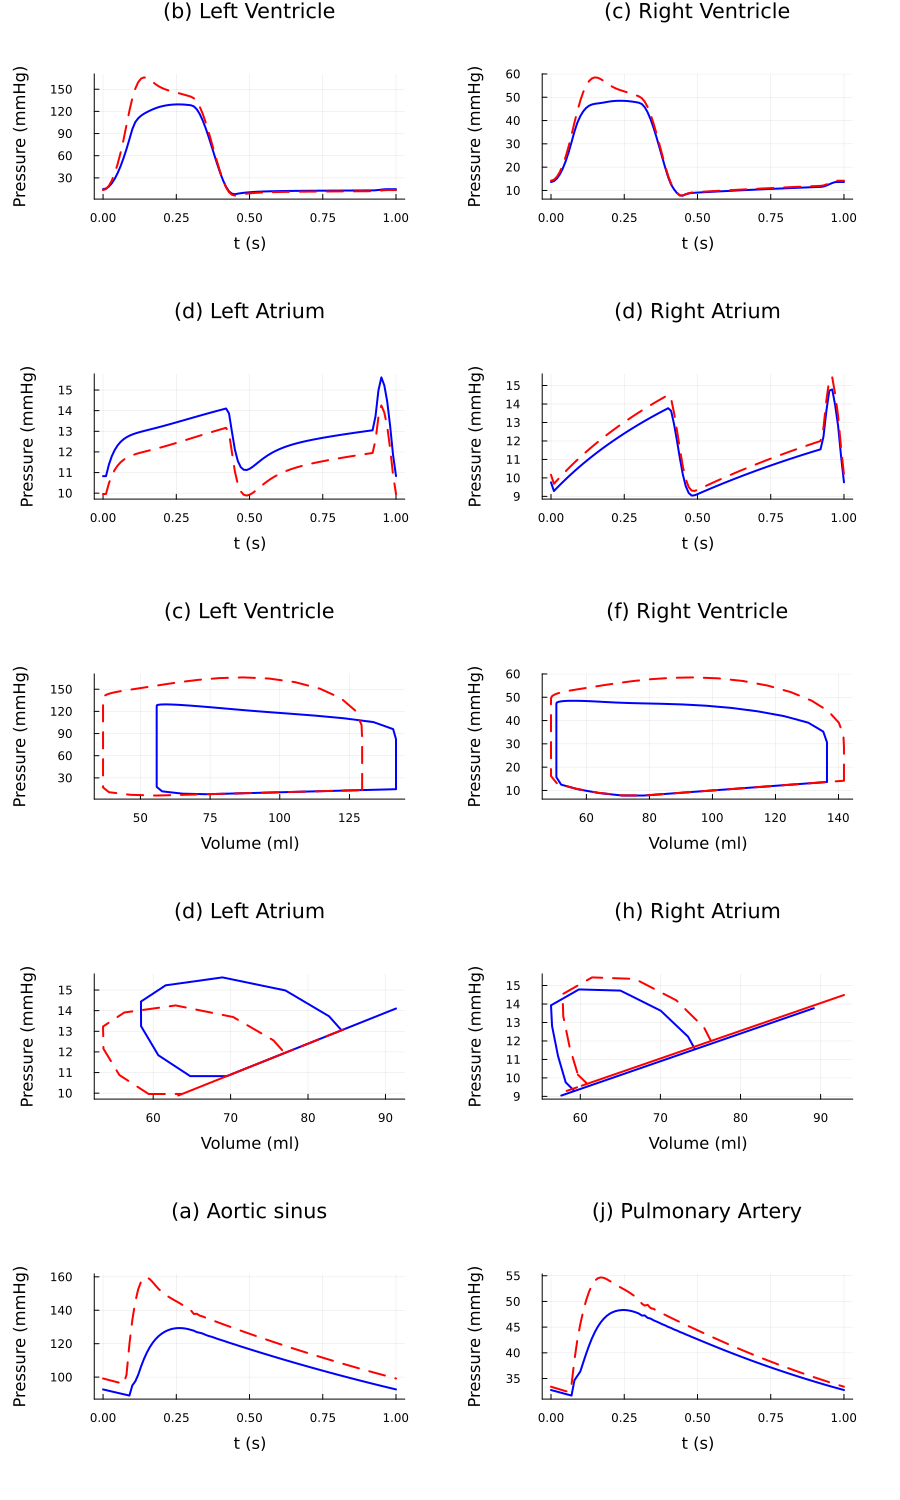

In [28]:
fig = plot(p_lv_pt, p_rv_pt, p_la_pt, p_ra_pt, p_lv_pv, p_rv_pv, p_la_pv, p_ra_pv, p_ao_pt, p_pa_pt,
        layout=(5,2), margin=10Plots.mm)
plot!(size=(900,1500))
# savefig(fig, "biatrial_plots/total_biatrial_results_1.pdf")